# Importing TensorFlow and Numpy

In [ ]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Defining the Parabolic PDE, Initial Condition and Boundry Condition to solve

#$\frac{\partial u}{\partial t} = K \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)$



#Definig Initial and Boundary conditions and PDE

In [ ]:
# X = [[x1,y1],[x2,y2],[x3,y3]]
def U_0(x): # Define initial condition
    return 0.5*tf.exp(-1*tf.reduce_mean(tf.square(x),axis = 1)/0.01) #gaussian fuction

def U_b(t, x): # Define boundary condition
    return tf.zeros((1,x.shape[0]), dtype='float32')

def PDE(t, x, u, u_t, u_x, u_xx): # Defining PDE to solve
    # Set constants
    k = 0.01
    return (u_t - k*tf.reshape(tf.linalg.trace(u_xx),(-1,1)))  # Take trace because u_xx will be on diagonal in hessian matrix

# Plotting to see the initial condition plot

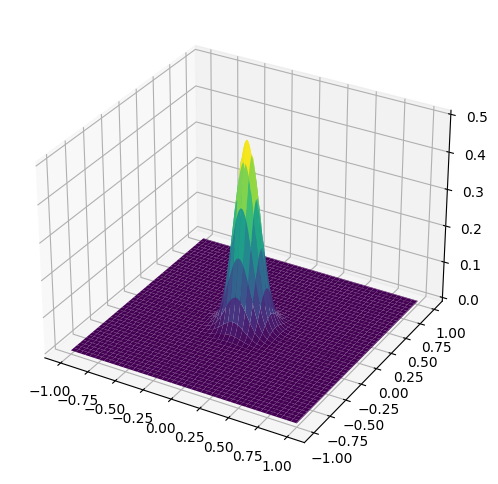

In [ ]:
N = 600
x1_space = np.linspace(-1, 1, N + 1)
x2_space = np.linspace(-1, 1, N + 1)
X1, X2 = np.meshgrid(x1_space, x2_space)
Xgrid = np.vstack([X1.flatten(),X2.flatten()]).T
Xgrid = tf.convert_to_tensor(Xgrid)
upred = np.array(U_0(Xgrid)).reshape(N+1,N+1)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2,upred, cmap='viridis');

# $Setting$ $(t,x)$ $Boundry$ $Values$

In [ ]:
# Set boundary
tmin = tf.constant(0.0, dtype='float32')
tmax = tf.constant(1.0, dtype='float32')

# Here we will be providing in mulit diminsinal form # Xmin = [[x1min,x2min]], Xmax = [[x1max,x2max]]
xmin = tf.constant([[-1.0,-1.0]], dtype='float32')
xmax = tf.constant([[1.0,1.0]], dtype='float32')

#  $Genrating$ $Random$ $points$ $from$ $Uniform$ $Distibution$

In [ ]:
# Set number of data points
N_0 = 100    ## Initial Condition
N_b = 100    ## Boundry Condition
N_i = 1000 ## Collocation points

# Set random seed for reproducible results
tf.random.set_seed(0)

- Draw uniform sample points for Initial Condition

In [ ]:
t_0 = tf.ones((N_0,1), dtype='float32')*tmin
x_0 = tf.stack([tf.random.uniform((N_0,), xmin[0][i], xmax[0][i], dtype='float32') for i in range(xmin.shape[1])],axis = 1)
X_0 = tf.concat([t_0, x_0], -1)

# Evaluate intitial condition at x_0
u_0 = U_0(x_0)

- Draw uniform sample points for Boundary Condition

In [ ]:
t_b = tf.random.uniform((N_b,1), tmin, tmax, dtype='float32')

x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((N_b,xmin.shape[1]), 0.5, dtype='float32')  ## Time can be anything (X= [+1,+1],[+1,-1],[-1,+1],[-1,-1] )
X_b = tf.concat([t_b, x_b], -1)

# # Evaluate boundary condition at (t_b,x_b)
u_b = U_b(t_b, x_b)

- Draw uniform sample Collocation Points

In [ ]:
t_i = tf.random.uniform((N_i,1), tmin, tmax, dtype='float32')
x_i = tf.stack([tf.random.uniform((N_i,), xmin[0][i], xmax[0][i], dtype='float32') for i in range(xmin.shape[1])],axis = 1)
X_i = tf.concat([t_i, x_i], -1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

# Plotting Data Generated

Fix x_b

<ipython-input-32-e28737b750ca>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(t_0, x_0[:,0],x_0[:,1], c='blue', marker='X', vmin=-1, vmax=1)
<ipython-input-32-e28737b750ca>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(t_b, x_b[:,0],x_b[:,1], c='green', marker='X', vmin=-1, vmax=1)


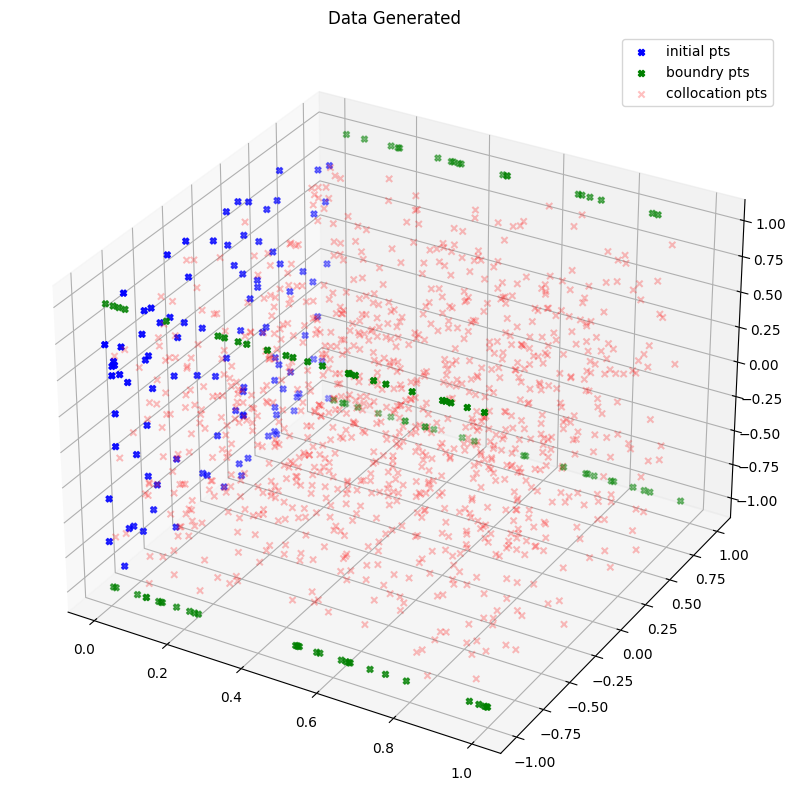

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
# ax.scatter(t_0, x_0[:,0],x_0[:,1], c='blue', marker='X', vmin=-1, vmax=1)
ax.scatter(t_0, x_0[:,0],x_0[:,1], c='blue', marker='X', vmin=-1, vmax=1)
# ax.scatter(t_b, x_b[:,0],x_b[:,1], c='green', marker='X', vmin=-1, vmax=1)
ax.scatter(t_b, x_b[:,0],x_b[:,1], c='green', marker='X', vmin=-1, vmax=1)
# ax.scatter(t_i, x_i[:,0],x_i[:,1], c='red', marker='x',alpha=0.25)
ax.scatter(t_i, x_i[:,0],x_i[:,1], c='red', marker='x',alpha=0.25)
# plt.xlabel('t',fontsize=15)
# plt.ylabel('x',fontsize=15)
plt.legend(["initial pts","boundry pts","collocation pts"])

plt.title('Data Generated');

# Defining the Neural Network

In [ ]:
def init_model(num_dims = 2,num_hidden_layers=4, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(1 + num_dims))

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh')))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

# *Calculating U, U<sub>$x$</sub>, U<sub>$t$</sub> ,U<sub>$xx$</sub> for PDE*

In [ ]:
def get_pde(model, X_i):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    # Persistent = True because, if false then tape gets deleted after one gradient calculation

    with tf.GradientTape(persistent=True) as t2:
      t, x = X_i[:,0:1], X_i[:,1::]
      t2.watch(t)
      t2.watch(x)
      with tf.GradientTape(persistent=True) as t1:
        # Variables t and x are watched during tape to compute derivatives u_t and u_x
        t1.watch(t)
        t1.watch(x)
        # Determine residual
        u = model(tf.concat([t, x], -1))

      # Compute gradient u_x within the GradientTape since we need second derivatives
      u_x = t1.gradient(u, x)
    u_t = t1.gradient(u, t)
    u_xx = t2.batch_jacobian(u_x, x) # calculating the hessian matrix
    del t1
    del t2
    return PDE(t, x, u, u_t, u_x, u_xx)

$
\mathbf{H}_f(\mathbf{x}_\mathbf{A}) = \begin{pmatrix}
\dfrac{\partial^2 f}{\partial {x_1}^2}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial^2 f}{\partial x_1\, \partial x_2}(\mathbf{x}_\mathbf{A})\\
\dfrac{\partial^2 f}{\partial x_2\,\partial x_1}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial^2 f}{\partial {x_2}^2}(\mathbf{x}_\mathbf{A})\\
\end{pmatrix}
$

# Computing The Loss Fuction for the PDE

In [ ]:
def compute_loss(model, X_i, X_data, u_data):

    # Compute L_r (Residual Loss)
    pde = get_pde(model, X_i)
    L_r = tf.reduce_mean(tf.square(pde))

    # Initialize loss
    loss = L_r

    # Add L_0 and L_b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

    return loss

# Getting Gradients for Trainable Neural Network Parameters

In [ ]:
def get_grad(model, X_i, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_i, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

# Initializing Model and Optimizer

In [ ]:
# Initialize model
model = init_model(num_dims = 2)

# Choose the optimizer

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000,6000],[1e-2,1e-3,5e-4,5e-5])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# Training the Model

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_i, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 100 iterates
    if i%200 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.30705491e-01
It 00200: loss = 2.07043160e-03
It 00400: loss = 2.10339180e-03
It 00600: loss = 2.06254772e-03
It 00800: loss = 2.10477598e-03
It 01000: loss = 2.06039241e-03
It 01200: loss = 2.06030346e-03
It 01400: loss = 2.06020870e-03
It 01600: loss = 2.06010370e-03
It 01800: loss = 2.05999077e-03
It 02000: loss = 2.05986877e-03
It 02200: loss = 2.05973932e-03
It 02400: loss = 2.05960171e-03
It 02600: loss = 2.05945596e-03
It 02800: loss = 2.05930462e-03
It 03000: loss = 2.05914723e-03
It 03200: loss = 2.05906411e-03
It 03400: loss = 2.05897633e-03
It 03600: loss = 2.05888320e-03
It 03800: loss = 2.05878518e-03
It 04000: loss = 2.05868273e-03
It 04200: loss = 2.05857540e-03
It 04400: loss = 2.05846387e-03
It 04600: loss = 2.05834908e-03
It 04800: loss = 2.05823057e-03
It 05000: loss = 2.05810997e-03
It 05200: loss = 2.05798773e-03
It 05400: loss = 2.05786317e-03
It 05600: loss = 2.05773953e-03
It 05800: loss = 2.05761520e-03
It 06000: loss = 2.05749297e-03
It 06200

# Plotting the Partial Differential Equation

$u(x,t) = \sum_{n=1}^{\infty} \frac{2}{n\pi} \left( 1 - (-1)^n \right) \cos(n\pi x) e^{-\lambda_n k t}$

where $\lambda_n = (n\pi)^2$.

In [ ]:
# def U(x,t):
#   return np.exp(-t)*np.sin(np.pi*x)

def U(x, t):
    L = 1  # length of domain
    k = 0.01  # thermal diffusivity
    u = np.zeros_like(x)
    # bn = 2 / (n * np.pi) * (1 - (-1)**n)
    # lambdan = (n * np.pi / L)**2
    # u += bn * np.cos(n * np.pi * x) * np.exp(-lambdan * k * t)
    for n in range(1, 100):
        bn = 2 / (n * np.pi) * (1 - (-1)**n)
        lambdan = (n * np.pi / L)**2
        u += bn * np.cos(n * np.pi * x) * np.exp(-lambdan * k * t)
    # u *= 0.5  # initial condition
    return u

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 100
tspace = np.linspace(tmin, tmax, N + 1)
xspace = np.linspace(xmin, xmax, N + 1)
T, X1, X2 = np.meshgrid(tspace, xspace[:,0,0],xspace[:,0,1])
Xgrid = np.vstack([T.flatten(),X1.flatten(),X2.flatten()]).T


# Actual Values
# uact = U(X,T)
# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,'float32'))

# Reshape upred
upred = model(tf.cast(Xgrid,'float32'))
U_pred = upred.numpy().reshape(N+1,N+1,N+1)
# U_pred = upred.numpy().reshape(N+1,N+1)
# U_act = uact.reshape(N+1,N+1)

# Surface plot of solution u(t,x)
# fig = plt.figure(figsize=(9,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(T, X, U_pred, cmap='viridis');
# ax.plot_surface(T, X, U_act);
# ax.view_init(35,35)
# ax.set_xlabel('t',fontsize=15)
# ax.set_ylabel('x',fontsize=15)
# ax.set_zlabel('$u_\\theta(t,x)$',fontsize=15,rotation=90)
# ax.set_title('Solution of Partial Differential Equation');

In [ ]:
U_pred[0,0,0]

0.0014018212

# Plotting Loss

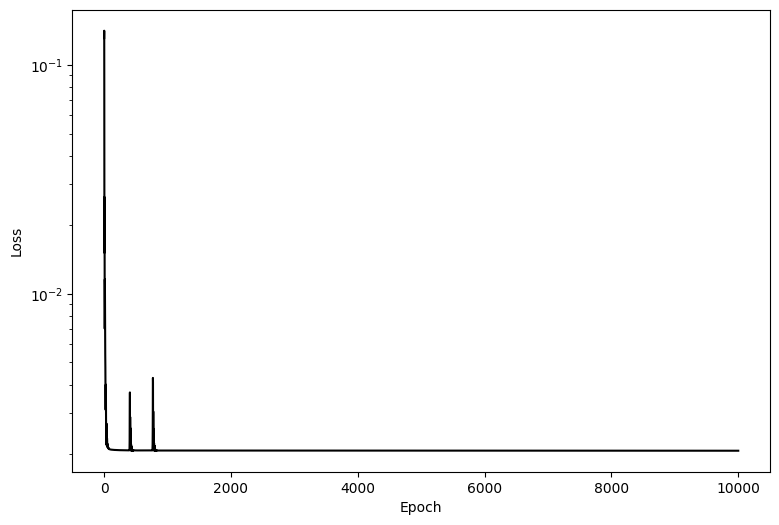

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss');